# Data

The dataset comes already with a train, validation and test split.

The training data contains 2000 images per class with 256x256 pixels per picture.
The validation set contains 100/200 images per class
and the testing data is filled with a random number
of images per class.

Since the project requires to have atleast 500 images per class and that 30% should be locked for the test set, 
we will only use the data contained in the training set and split it ourselves.

TODO: b) In the notebook, cite and describe your dataset properly (data source, pre-processing)


In [56]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #Workaround for kernel crash because multiple copies of the OpenMP runtime have been linked

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers


In [49]:
#Set os env variable. Only required if not already set.
os.environ["aiap_data_path"] = "C:/Users/mrcls/temp_dataset/animals/data"

In [59]:
data_path = os.environ["aiap_data_path"]
batch_size = 32
img_height = 256
img_width = 256
img_channels = 3 #RGB
shuffle_seed = 1234
test_data_ratio = 0.3
validation_data_ratio= 0.2
img_classes = [ #explicitly define the used classes to avoid errors
    "Cow",
    "Dog",
    "Elephant",
    "Gorilla",
    "Hippo",
    "Lizard",
    "Monkey",
    "Panda",
    "Tiger",
    "Zebra"
    ]


In [51]:
#Load the data and split
#A tf.data.Dataset object
data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, #directory where data is located
    class_names=img_classes, #pass in names of classes
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True, #shuffle the data
    seed=shuffle_seed, #seed for the shuffling and transformations
    validation_split=test_data_ratio, #we reserve 30% of the data for the test set
    subset="both",
)
print("do not confuse the output here. we explicitly use the validation data as test data and split the training data again for the validation data")

Found 20000 files belonging to 10 classes.
Using 14000 files for training.
Using 6000 files for validation.
do not confuse the output here. we explicitly use the validation data as test data and split the training data again for the validation data


In [52]:
print("data variable contains:",len(data),"elements")
training_data= data[0]
test_data = data[1]
assert isinstance(training_data, tf.data.Dataset)
assert isinstance(test_data, tf.data.Dataset)

print("training data size:",training_data.cardinality())
print("test data size:", test_data.cardinality())
print("class names:", training_data.class_names)


data variable contains: 2 elements
training data size: tf.Tensor(438, shape=(), dtype=int64)
test data size: tf.Tensor(188, shape=(), dtype=int64)
class names: ['Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Panda', 'Tiger', 'Zebra']


In [53]:

training_data_size = sum(1 for _ in training_data)
print(training_data_size, "batches")
validation_data_size = int(validation_data_ratio * training_data_size)
print(validation_data_size, "batches")
validation_data = training_data.take(validation_data_size)
class_names = training_data.class_names
training_data = training_data.skip(validation_data_size)

438 batches
87 batches


{'_input_dataset': <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, '_count': <tf.Tensor: shape=(), dtype=int64, numpy=87>, '_name': None, '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<SkipDatasetOp::Dataset>>, '_graph_attr': <tensorflow.python.framework.ops.Graph object at 0x00000237CECDFC70>, '_options_attr': <tensorflow.python.data.ops.options.Options object at 0x00000237F29EA770>}


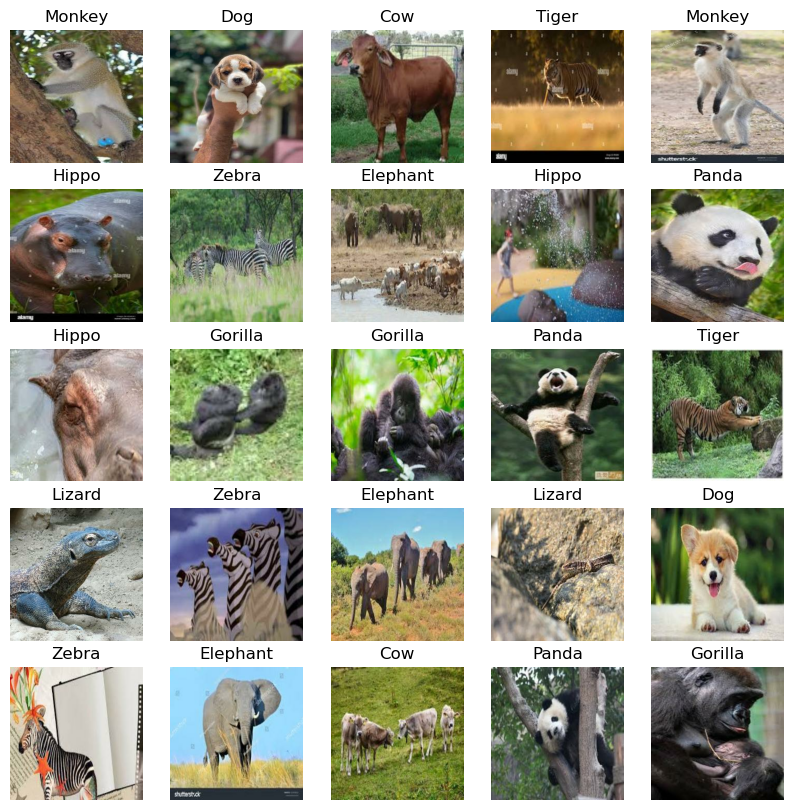

In [54]:
plt.figure(figsize=(10, 10))
print(vars(training_data))
for images, labels in training_data.take(1):
  for i in range(25):
    try:
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
    except Exception as e:
      print(f"Error at index {i}: {e}")

# Model 1

In [60]:
simple_model = models.Sequential()
simple_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)))
simple_model.add(layers.MaxPooling2D((2, 2)))
simple_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
simple_model.add(layers.MaxPooling2D((2, 2)))
simple_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
simple_model.add(layers.Flatten())
simple_model.add(layers.Dense(64, activation='relu'))
simple_model.add(layers.Dense(10))
simple_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai